In [1]:
import copy
import numpy as np
import os
import palettable
import verdict

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 600, galdef _galdefv3


In [8]:
tag_tail = '_CGM_snum{}'.format( snum )

In [9]:
ahf_index = 600

In [10]:
ind = ahf_index - snum

In [11]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_origin' )

In [12]:
sim_names = [
    'm12i',
#     'm12f',
#     'm12m',
#     'm12c_md',
#     'm12r_md',
#     'm12w_md',
]

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = sim_names,
    galdef = galdef,
)

In [14]:
defaults

{'ahf_index': 600,
 'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
 'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
 'ids_tag': 'm12i_CGM_snum600',
 'main_halo_id': 0,
 'ptracks_tag': 'm12i_CGM_snum600',
 'tag': 'm12i_CGM_snum600_galdefv3'}

In [15]:
variations

{'m12i': {}}

In [16]:
w_set = a_w_set.WorldlineSet( defaults, variations )

# Analyze Data

In [17]:
w_set.data_object.retrieve_halo_data()
halo_masses = w_set.data_object.m_vir.inner_item( snum )

In [18]:
# Start from a fresh slate
w_set.data_object.data_masker.clear_masks( True )
# Choose only gas
w_set.data_object.data_masker.mask_data( 'PType', data_value=linefinder_config.PTYPE_GAS )

# Set up classifications
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
# classification_list.remove( 'is_CGM_satellite' )
classification_list.insert( 0, 'is_in_CGM' )

In [19]:
# Set up mass bins
mass_bins = [ 'm12', ]

In [20]:
# Loop through classifications and get raw data

radii = verdict.Dict({})
densities = verdict.Dict({})
masses = verdict.Dict({})
vr_comps = verdict.Dict({})
for classification in classification_list:

    print( classification )
    
    radii[classification] = w_set.data_object.get_selected_data(
        'R',
        scale_key = 'Rvir',
        scale_a_power = 1.,
        scale_h_power = -1.,
        sl = (slice(None),ind),
        classification = classification,
    )
    
    densities[classification] = w_set.data_object.get_selected_data(
        'HDen',
        sl = (slice(None),ind),
        classification = classification,
    )
    
    masses[classification] = w_set.data_object.get_selected_data(
        'M',
        sl = (slice(None),ind),
        classification = classification,
    )
    
    vr_comps[classification] = w_set.data_object.get_selected_data(
        'vr_div_v_cool',
        sl = (slice(None),ind),
        classification = classification,
    )

is_in_CGM


/home1/03057/zhafen/repos/linefinder/linefinder/analyze_data/worldlines.py:1271: RuntimeWarning: divide by zero encountered in divide
  self.get_data( 'R' ) / self.get_data('t_cool_lookup')


is_CGM_IGM_accretion
is_CGM_wind
is_CGM_satellite_wind
is_CGM_satellite_ISM


In [21]:
# Calculate the volumes. Note that the units are weird for these volumes, since it's mass
# divided by a number density
volumes = masses / densities

In [22]:
# Choose one of the plotters to plot data with. It doesn't matter which one,
# because we'll be passing data
w_plotter = w_set['m12i']
w = w_plotter.data_object

In [29]:
# Get the minimum radii to plot to
split_radii = radii['is_in_CGM'].split_by_dict( linefinder_config.MASS_BINS )
min_radii = {}
for key, item in split_radii.items():
    n_min = 3
    
    percentile = n_min / float( len( item ) ) * 100.
    print( percentile )
    
    if len( item ) == 1:
        min_radii[key] = item.values()[0].min()
    else:
        min_radii[key] = np.percentile( item.min().array(), percentile  )

300.0


### Data Storage

In [30]:
all_data = verdict.Dict({})

# Compare to Stern+19

File saved at /work/03057/zhafen/extra_plots/CGM_origin/CGM_vr_profile_snum600.pdf


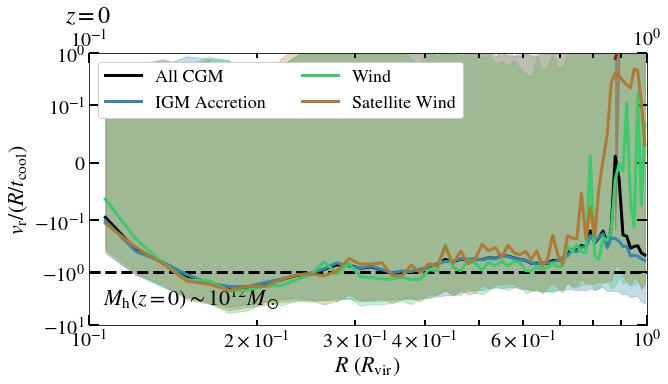

In [40]:
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

vr_data = verdict.Dict({})

handles, labels = [], []
for j, mass_bin in enumerate( mass_bins ):
    
    vr_data[mass_bin] = verdict.Dict({})

    for i, classification in enumerate( classification_list ):
                
        ax = plt.subplot(gs[j,0])

        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        vr_comps_bin = vr_comps[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        volumes_bin = volumes[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        # Don't plot classifications when there are sims that have <100 particles
        # with that classification
        if radii_bin.size.array().min() < 100:
            continue
            
        vr_data[mass_bin][classification] = verdict.Dict({})
            
        med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
            'R',
            'vr_div_v_cool',
            statistic = 'mean',
            x_data = np.concatenate( radii_bin.array() ),
            y_data = np.concatenate( vr_comps_bin.array() ),
#             weights = np.concatenate( volumes_bin.array() ),
            slices = ind,
            ax = ax,
            x_data_args = {
                'scale_key': 'Rvir',
                'scale_a_power': 1.,
                'scale_h_power': -1.,
            },
            plot_interval = classification != 'is_in_CGM',
            fix_invalid = True,
            zorder = 1000,
            classification = classification,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            label = p_constants.CLASSIFICATION_LABELS[classification],
            plot_label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
            add_plot_label = ( i == 0 ),
            plot_label_kwargs = {
                'fontsize': 22,
                'xy': ( 0.025, 0.05, ),
                'xycoords': 'axes fraction',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'left',
            },
            return_values = True,
            bins = np.linspace( min_radii[mass_bin], 1., 64 ),
            alpha = 0.3,
        )
        
        # Store data
        vr_data[mass_bin][classification]['volume_weighted_mean'] = med
        vr_data[mass_bin][classification]['16th_percentile'] = low_p
        vr_data[mass_bin][classification]['84th_percentile'] = high_p
        x_values = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )
        vr_data[mass_bin][classification]['x_values'] = x_values

        # Limits and scale tweaking
        y_lims = {
            465: [ 2e-6, 1e-1 ],
            172: [ 5e-5, 4e-1 ],
        }
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( -10, 1 )
        ax.set_xscale( 'log' )
        ax.set_yscale( 'symlog', linthreshy=0.1 )

        # Labels
        ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        ax.set_ylabel( r'$v_{\rm r} / ( R / t_{\rm cool} )$', fontsize=22, )
        
        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
        # Plot label
        if ax.is_first_row() and classification == 'is_in_CGM':
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
                xy = ( 0.0, 1.0 ),
                xytext = ( 0., 25., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'center',
                verticalalignment = 'bottom',
                fontsize = 24,
            )
            
        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Legend, including tweaking
        if classification == 'is_CGM_satellite_wind':
            # Reorder labels and preserve to slap them on the last plot
            handles, labels = ax.get_legend_handles_labels()
#             for i, gamma in enumerate( gammas ):
#                 handles.append( handles[1] )
#                 labels.append( labels[1] )
#                 handles.remove( handles[1] )
#                 labels.remove( labels[1] )
        if ax.is_last_row():
            loc = {
                465: None,
                172: 'upper left',
            }
            ax.legend(
                handles,
                labels,
                prop = { 'size': 18 },
#                 loc = loc[snum],
                ncol = 2,
                framealpha = 1.,
                fontsize = 18
            )
            

ax.axhline(
    -1,
    color = 'k',
    linewidth = 3,
    linestyle = '--',
)
            
# Save the File
save_file = 'CGM_vr_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.project_parameters['extras_dir'],
    save_file = save_file,
    fig = fig,
)

all_data['vr'] = vr_data

In [ ]:
assert False